In [1]:
# default_exp discography

# Discography Processing

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import FEAutils as hlp
import matplotlib.pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import os
import re
import json
import html
import dotenv
import requests
import functools

from warnings import warn
from ipypb import track

In [36]:
from IPython.display import HTML, IFrame, JSON, Audio, Image

<br>

### Spotipy Client Initialisation

In [3]:
_ = dotenv.load_dotenv('../.env')

In [4]:
#exports
def initialise_spotify_client():
    client_id = os.getenv('SPOTIFY_ID')
    client_secret = os.getenv('SPOTIFY_SECRET')
    
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    return sp

In [5]:
sp = initialise_spotify_client()

sp

In [6]:
#exports
def setup_client_scopes():
    client_id = os.getenv('SPOTIFY_ID')
    
    spotify_auth_url = 'https://accounts.spotify.com/authorize'
    scopes = ['user-read-private', 'user-modify-playback-state', 'user-read-currently-playing', 'user-read-recently-played', 'user-read-playback-state', 'playlist-read-collaborative']
    
    query_params = {
        'client_id' : client_id,
        'response_type' : 'code',
        'redirect_uri' : 'http://osuked.com',
        'scope' : ' '.join(scopes)
    }
    
    r = requests.get(spotify_auth_url, params=query_params)
    
    return r

In [7]:
r = setup_client_scopes()

r

<Response [200]>

<br>

### Helper Functions

In [8]:
#exports
def try_accept(exception=np.nan):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                return exception
        return wrapper
    return decorator

<br>

### Specifying Artist

Here we'll specify the artist we want to get data for, as well as an album that we'll use later for examples

In [9]:
artist = 'A Tribe Called Quest'
album = 'Beats, Rhymes and Life'

<br>

### Collecting Discography

We start by retrieving a table listing their discography from Wikipedia

In [10]:
#exports
def load_artist_discog(artist):
    wiki_discog_url = f"https://en.wikipedia.org/wiki/{artist.replace(' ', '_')}_discography"

    tables = pd.read_html(wiki_discog_url)
    df_discog = tables[1]

    if isinstance(df_discog.columns, pd.MultiIndex):
        df_discog.columns = df_discog.columns.get_level_values(0)

    df_discog = df_discog.drop(df_discog.index[df_discog['Title'].str.contains('"—" denotes')])

    return df_discog

In [11]:
df_discog = load_artist_discog(artist)

df_discog.head(3)

,Title,Album details,Peak chart positions,Peak chart positions,Peak chart positions,Peak chart positions,Peak chart positions,Certifications,Unnamed: 8_level_0,Unnamed: 9_level_0,Unnamed: 10_level_0,Unnamed: 11_level_0,Unnamed: 12_level_0,Unnamed: 13_level_0,Unnamed: 14_level_0,Unnamed: 15_level_0,Unnamed: 16_level_0,Unnamed: 17_level_0,Unnamed: 18_level_0,Unnamed: 19_level_0
0,People's Instinctive Travels and the Paths of ...,"Released: April 17, 1990 Label: Jive, RCA Reco...",91,23,—,—,54,RIAA: Gold[13],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Low End Theory,"Released: September 24, 1991 Label: Jive Forma...",45,13,—,—,58,RIAA: Platinum[13],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Midnight Marauders,"Released: November 9, 1993 Label: Jive Format:...",8,1,48,—,70,RIAA: Platinum[13],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

We then clean this up a bit

In [12]:
#exports
def extract_album_dates(df_discog):
    cols_2_keep = ['Title', 'Album details']

    df_album_dates = df_discog[cols_2_keep].copy()
    df_album_dates.columns = cols_2_keep

    s_dt = (df_album_dates
            ['Album details']
            .str[10:]
            .str.split(' ')
            .apply(lambda l: ' '.join(l[:3]))
           )

    df_album_dates = (df_album_dates 
                      .assign(Date=pd.to_datetime(s_dt))
                      .drop(columns='Album details')
                     )

    return df_album_dates

In [13]:
df_album_dates = extract_album_dates(df_discog)

df_album_dates

,Title,Date
0,People's Instinctive Travels and the Paths of ...,1990-04-17
1,The Low End Theory,1991-09-24
2,Midnight Marauders,1993-11-09
3,"Beats, Rhymes and Life",1996-07-30
4,The Love Movement,1998-09-29
5,We Got It from Here... Thank You 4 Your Service,2016-11-11


<br>

### Retrieving Album & Song Data

First we create a spotipy instance and test it out on a single album

In [14]:
#exports
@try_accept()
def name_2_album_meta(album, sp, artist=None):
    if artist is not None:
        query = f'{album} {artist}'
    else:
        query = album
        
    result = sp.search(query, type='album') 
    s_first_album = pd.Series(result['albums']['items'][0])
    
    return s_first_album 

In [15]:
s_first_album = name_2_album_meta(album, sp, artist)

s_first_album

album_type                                                            album
artists                   [{'external_urls': {'spotify': 'https://open.s...
available_markets         [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...
external_urls             {'spotify': 'https://open.spotify.com/album/0E...
href                      https://api.spotify.com/v1/albums/0EguP4tsJurU...
id                                                   0EguP4tsJurU5I8ocCxdyb
images                    [{'height': 640, 'url': 'https://i.scdn.co/ima...
name                                                   Beats, Rhymes & Life
release_date                                                     1996-07-30
release_date_precision                                                  day
total_tracks                                                             15
type                                                                  album
uri                                    spotify:album:0EguP4tsJurU5I8ocCxdyb
dtype: objec

<br>

We'll add a helper function which will check that the release dates provided by Wikipedia and Spotify are consistent with each other

In [16]:
#exports
def check_release_date_consistency(df, s_first_album, album_name, td_val=150, td_units='days'):
    release_date_precision = pd.Timedelta(td_val, unit=td_units)
    
    assert isinstance(s_first_album, pd.Series), 's_first_album must be a Pandas series'
    release_date_sp = pd.to_datetime(s_first_album['release_date'])
    release_date_wiki = df.set_index('Title').loc[album_name, 'Date']

    release_delta = release_date_sp - release_date_wiki
    assert release_delta <= release_date_precision, f"The '{album_name}' release date on Spotify - {release_date_sp.date()}- and Wikipedia - {release_date_wiki.date()} - were inconsistent"

    return

In [17]:
check_release_date_consistency(df_album_dates, s_first_album, album)

<br>

Next we'll extract the relevant data and parse it into a dataframe

In [18]:
#exports
def df_album_dates_to_spotify_meta(df_album_dates):
    albums = dict()

    for album_name in df_album_dates['Title']:
        try:
            albums[album_name] = name_2_album_meta(album_name, sp, artist)
            check_release_date_consistency(df_album_dates, albums[album_name], album_name)
        except:
            albums.pop(album_name)
            warn(f'{album_name} could not be processed')

    df_albums_meta = pd.DataFrame(albums).T
    df_albums_meta.index.name = 'album_name'

    return df_albums_meta

In [19]:
%%time

df_albums_meta = df_album_dates_to_spotify_meta(df_album_dates)

df_albums_meta.head(3)

Wall time: 606 ms


,album_type,artists,available_markets,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri
album_name,,,,,,,,,,,,,
People's Instinctive Travels and the Paths of Rhythm,album,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/3k...,https://api.spotify.com/v1/albums/3kV0i1qqudjf...,3kV0i1qqudjf0PGawJ4jck,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",People's Instinctive Travels and the Paths of ...,1990-04-17,day,17,album,spotify:album:3kV0i1qqudjf0PGawJ4jck
The Low End Theory,album,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/1p...,https://api.spotify.com/v1/albums/1p12OAWwudgM...,1p12OAWwudgMqfMzjMvl2a,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Low End Theory,1991-09-24,day,14,album,spotify:album:1p12OAWwudgMqfMzjMvl2a
Midnight Marauders,album,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/4v...,https://api.spotify.com/v1/albums/4v5x3Oo3UjQ9...,4v5x3Oo3UjQ9YmF3hRAip5,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Midnight Marauders,1993-11-09,day,14,album,spotify:album:4v5x3Oo3UjQ9YmF3hRAip5


<br>

Whilst we've just filtered for the information that will be most important for us later in the analysis, we have still collected all of the other album metadata - e.g. the cover art.

In [20]:
album_art_url = df_albums_meta.loc[album]['images'][0]['url']

Image(url=album_art_url, height=250, width=250)

<br>

The next step in the process is to retrieve information about the album songs

In [21]:
album_id = df_albums_meta.loc[album]['id']
album_uri = f'spotify:album:{album_id}'

album_tracks = sp.album_tracks(album_uri)
num_tracks = len(album_tracks['items'])

example_track = album_tracks['items'][-1]
s_example_track = pd.Series(example_track)

print(f"There are {num_tracks} tracks on '{album}'\n\nExample track data:")
s_example_track

There are 15 tracks on 'Beats, Rhymes and Life'

Example track data:


artists              [{'external_urls': {'spotify': 'https://open.s...
available_markets    [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...
disc_number                                                          1
duration_ms                                                     298200
explicit                                                          True
external_urls        {'spotify': 'https://open.spotify.com/track/3j...
href                 https://api.spotify.com/v1/tracks/3jaEmUzw0Nt4...
id                                              3jaEmUzw0Nt4GcyPkWEDCi
is_local                                                         False
name                                  Stressed Out (feat. Faith Evans)
preview_url          https://p.scdn.co/mp3-preview/f8bb659c83432f14...
track_number                                                        15
type                                                             track
uri                               spotify:track:3jaEmUzw0Nt4GcyPkWEDCi
dtype:

<br>

Thanks to the IPython team we can listen to an audio sample without leaving a notebook

In [22]:
example_track_sample = f"{example_track['preview_url']}.mp3"

Audio(example_track_sample)

<br>

We can create a dataframe from the most relevant columns

In [23]:
df_album_songs = pd.DataFrame(album_tracks['items'])[['uri', 'name', 'preview_url', 'track_number']]

df_album_songs.head()

,uri,name,preview_url,track_number
0,spotify:track:0PukerHwImpQ2axWQEV1WQ,Phony Rappers,https://p.scdn.co/mp3-preview/6587e9e80be22308...,1
1,spotify:track:1LuvccUiy1j9y8hpPBzQNh,Get A Hold,https://p.scdn.co/mp3-preview/e0ec414c92b0187a...,2
2,spotify:track:34DES5skEhdS6cuD9JUuVo,Motivators,https://p.scdn.co/mp3-preview/b5d5d542c2c125d0...,3
3,spotify:track:0kMDFI2uqA16c8rWzXWlAU,The Jam,https://p.scdn.co/mp3-preview/86177826b09b1539...,4
4,spotify:track:4uOHIgf61scTZ356kvFA1Z,Crew,https://p.scdn.co/mp3-preview/86ed3efb86770a2c...,5


<br>

We'll now repeat the steps of retrieving the song information and filtering for the relevant columns, the album name will then be added before combining the dataframes into a single object.

In [24]:
#exports
def extract_all_songs_in_albums(df_albums_meta):
    df_songs = pd.DataFrame()

    album_2_release_date = (df_albums_meta
                            ['release_date']
                            .apply(lambda dt: pd.to_datetime(dt).date())
                            .to_dict()
                           )

    for album_name in track(df_albums_meta.index):
        album_id = df_albums_meta.loc[album_name, 'id']
        album_uri = f'spotify:album:{album_id}'

        album_tracks = sp.album_tracks(album_uri)

        df_album_songs = pd.DataFrame(album_tracks['items'])[['uri', 'name', 'preview_url', 'track_number']]

        df_album_songs['album'] = album_name
        df_album_songs['album_release'] = album_2_release_date[album_name]

        df_songs = df_songs.append(df_album_songs)
        
    return df_songs

In [25]:
%%time

df_songs = extract_all_songs_in_albums(df_albums_meta)
    
df_songs.head()

 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.07s/it]

Wall time: 409 ms


,uri,name,preview_url,track_number,album,album_release
0,spotify:track:2Qoui6iAiX1VVV21yWayBD,Push It Along,https://p.scdn.co/mp3-preview/58d38b662e07e969...,1,People's Instinctive Travels and the Paths of ...,1990-04-17
1,spotify:track:7EhEPcPa60LlvGuG9R1DOx,Luck of Lucien,https://p.scdn.co/mp3-preview/b704ea6cbb92aa70...,2,People's Instinctive Travels and the Paths of ...,1990-04-17
2,spotify:track:5MNch1DaIp20fiHKmLHcp0,After Hours,https://p.scdn.co/mp3-preview/e7b19f0aee6bfc97...,3,People's Instinctive Travels and the Paths of ...,1990-04-17
3,spotify:track:3trSZ6JhgNpDhTfRvge4go,Footprints,https://p.scdn.co/mp3-preview/c0bfdf02baddcbc4...,4,People's Instinctive Travels and the Paths of ...,1990-04-17
4,spotify:track:15Xdlu0QaiEy3YFTf4xpUA,I Left My Wallet in El Segundo,https://p.scdn.co/mp3-preview/057d7643f457dc11...,5,People's Instinctive Travels and the Paths of ...,1990-04-17


<br>

We can now request the features that Spotify derives for every song

In [33]:
features_2_keep = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
                   'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode', 'time_signature']

example_track_uri = s_example_track['uri']
s_example_track_analysis = pd.Series(sp.audio_features(example_track_uri)[0])[features_2_keep]

s_example_track_analysis

danceability         0.823000
energy               0.399000
key                         7
loudness           -10.108000
speechiness          0.234000
acousticness         0.071200
instrumentalness     0.000258
liveness             0.095400
valence              0.577000
tempo               93.524000
duration_ms            298200
mode                        1
time_signature              4
dtype: object

<br>

We'll do this for every song

In [34]:
#exports
def retrieve_track_analysis(df_songs, track_uri_col='uri', sp=None):
    if sp is None:
        sp = initialise_spotify_client()
        
    df_songs_analysis = pd.DataFrame()
    
    features_2_keep = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
                       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode', 'time_signature']

    for track_idx, track_data in track(df_songs.iterrows(), total=df_songs.shape[0]):
        example_track_uri = track_data[track_uri_col]

        s_example_track_analysis = pd.Series(sp.audio_features(example_track_uri)[0])[features_2_keep]
        df_songs_analysis[track_idx] = s_example_track_analysis

    df_songs[df_songs_analysis.index] = df_songs_analysis.T
    
    return df_songs

In [28]:
df_songs = retrieve_track_analysis(df_songs)

df_songs.head(2)

 [████████████████████████████████████████████████████████████] 97/97 [00:06<00:00, 0.06s/it]

,uri,name,preview_url,track_number,album,album_release,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,spotify:track:2Qoui6iAiX1VVV21yWayBD,Push It Along,https://p.scdn.co/mp3-preview/58d38b662e07e969...,1,People's Instinctive Travels and the Paths of ...,1990-04-17,0.612,0.705,1,-5.898,0.3520,0.42700,0,0.658,0.533,101.876,341040
1,spotify:track:7EhEPcPa60LlvGuG9R1DOx,Luck of Lucien,https://p.scdn.co/mp3-preview/b704ea6cbb92aa70...,2,People's Instinctive Travels and the Paths of ...,1990-04-17,0.710,0.805,1,-5.471,0.0637,0.00909,0,0.141,0.897,92.601,172013


<br>

We can already start to explore some patterns such as how/if an artist varies over time for a particular Spotify feature

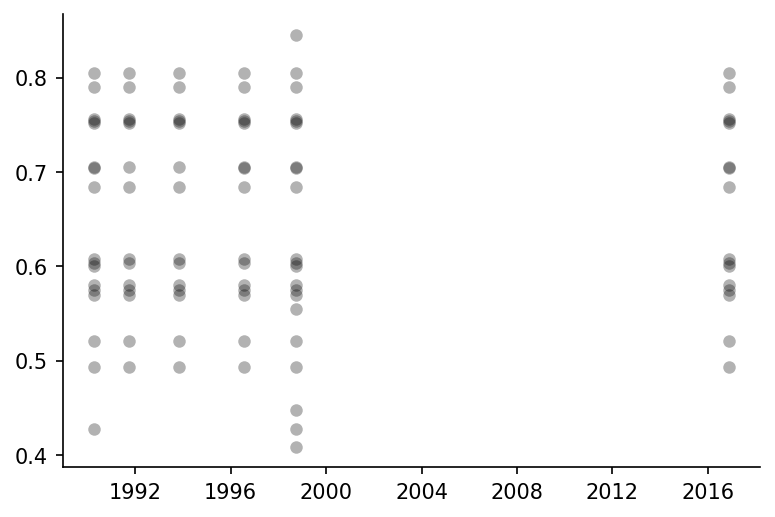

In [29]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_songs['album_release'], df_songs['energy'], alpha=0.3, color='k', linewidth=0)

hlp.hide_spines(ax)

<br>

We can also use Seaborn to create density plots for each feature

C:\Users\Ayrto\anaconda3\envs\SpotifyWatch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ayrto\anaconda3\envs\SpotifyWatch\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\Ayrto\anaconda3\envs\SpotifyWatch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg,

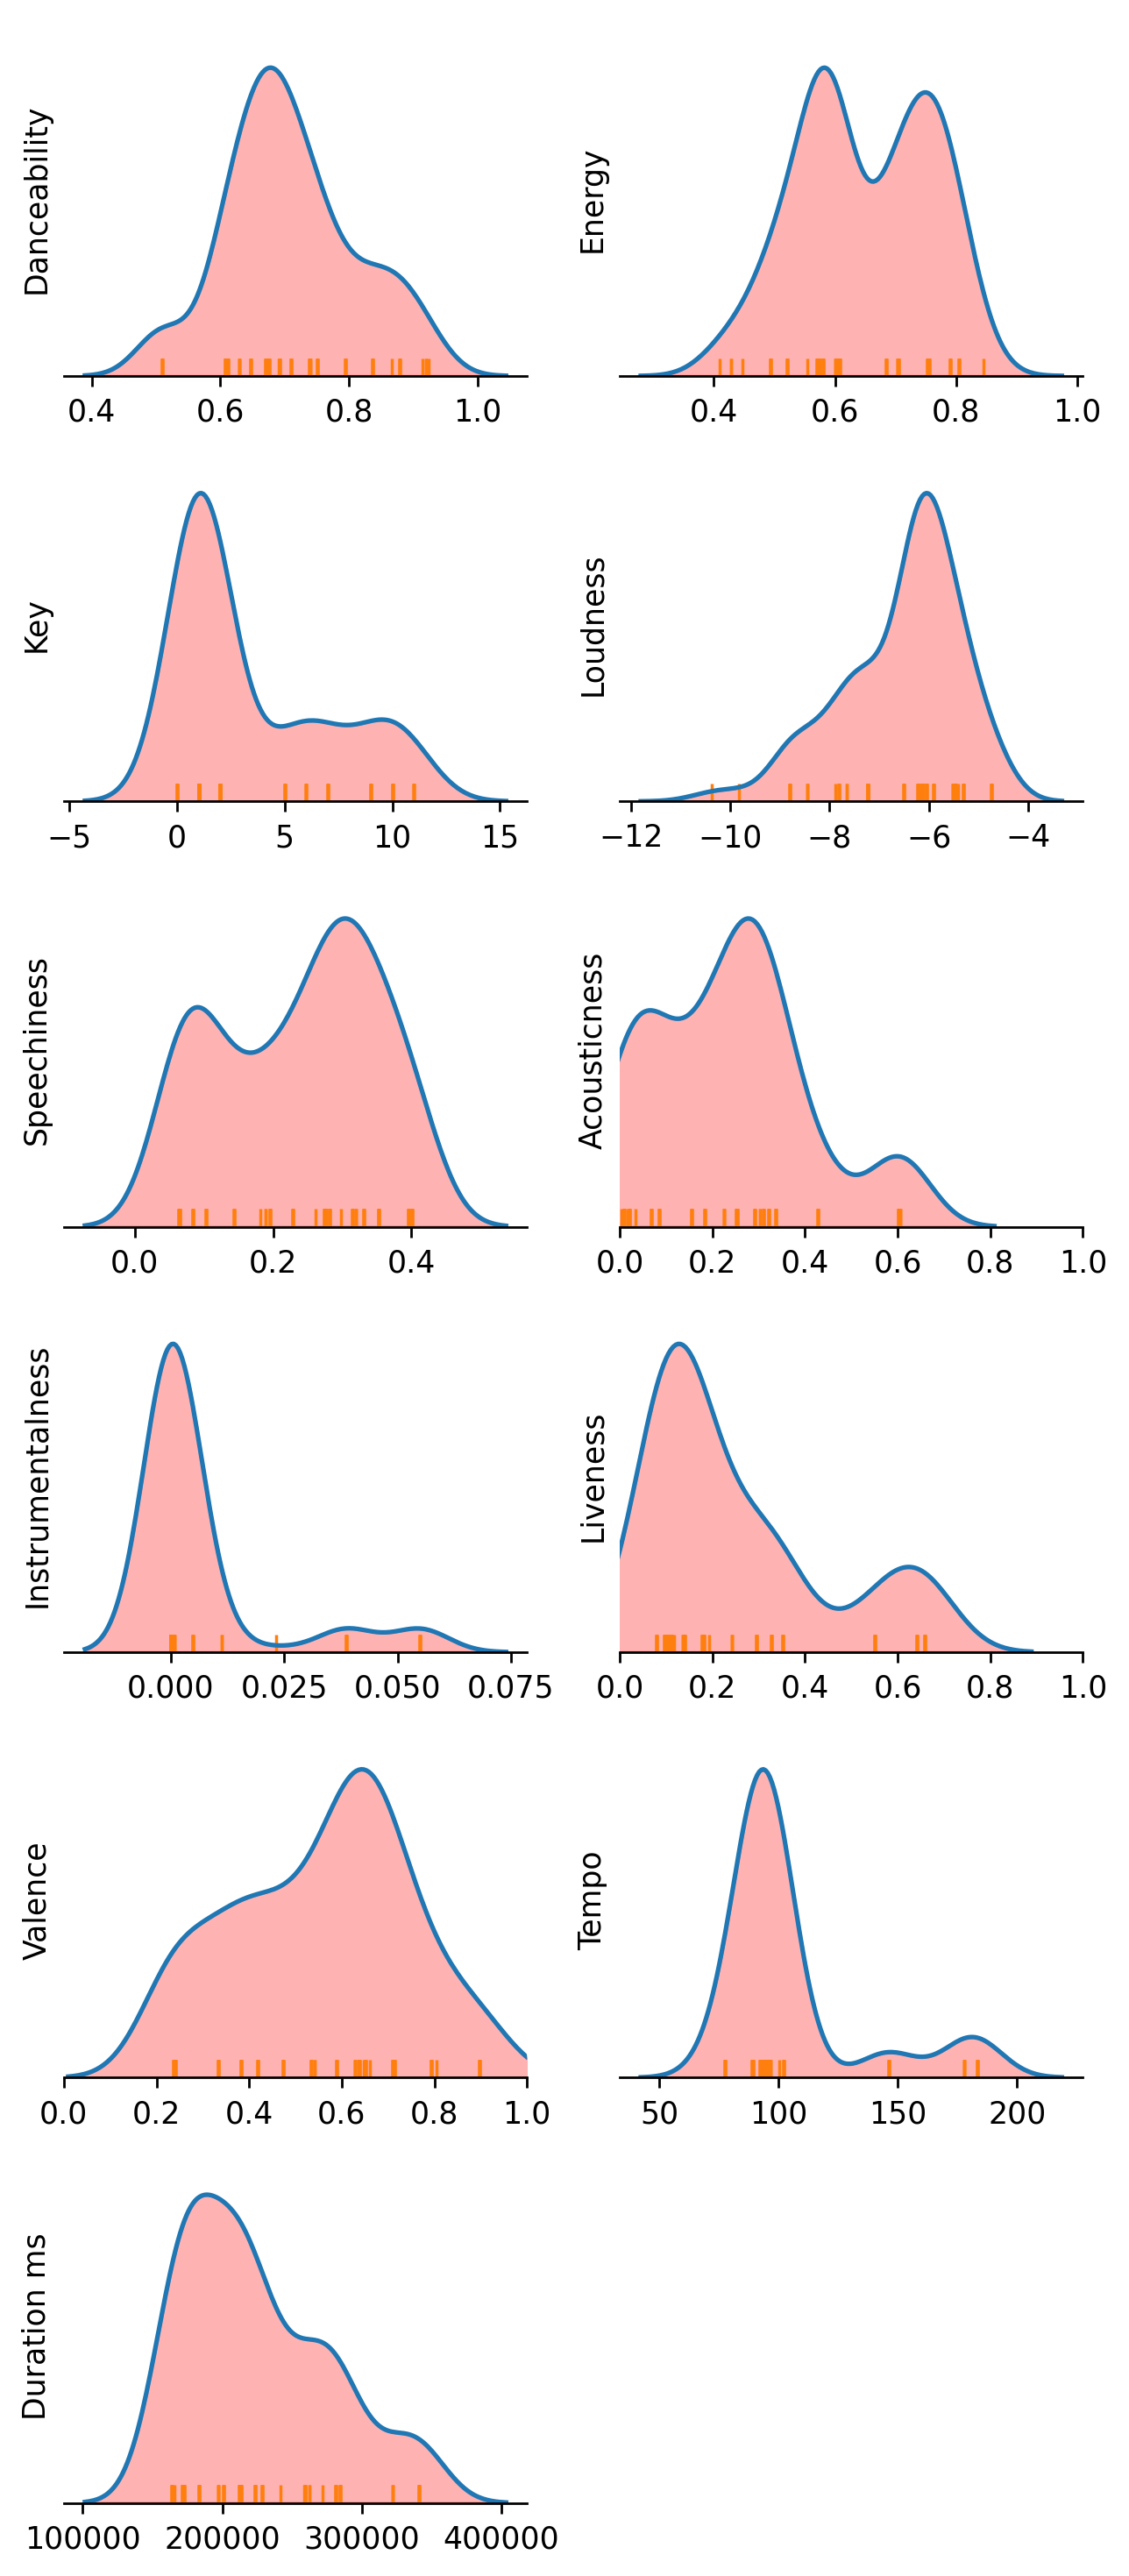

In [30]:
nrows = int(np.ceil(len(features_2_keep)/2))

fig, axs = plt.subplots(dpi=250, nrows=nrows, ncols=2, figsize=(6, 15))
axs = axs.flatten()

for ax_idx, feature in enumerate(features_2_keep):
    s_feature = df_songs[feature]
    ax = axs[ax_idx]
    
    # plotting
    sns.distplot(s_feature, hist=False, ax=ax)
    sns.rugplot(s_feature, height=0.05, axis='x', ax=ax)
    
    # filling the density plot
    l = ax.lines[0]
    KDE_x = l.get_xydata()[:,0]
    KDE_y = l.get_xydata()[:,1]
    ax.fill_between(KDE_x, KDE_y, color='red', alpha=0.3)

    # handling aesthetics
    hlp.hide_spines(ax, positions=['top', 'left', 'right'])
    
    # y axis
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel(f"{feature.replace('_', ' ').capitalize()}")

    ## x axis
    ax.set_xlabel('')
    if s_feature.min()>0 and s_feature.max()<1 and (s_feature.max() - s_feature.min()) > 0.5:
        ax.set_xlim(0, 1)
        
if nrows != len(features_2_keep)/2:
    hlp.hide_spines(axs[-1], positions=['top', 'bottom', 'left', 'right'])
    axs[-1].set_xticks([])
    axs[-1].set_yticks([])

In [35]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-discography.ipynb.
Converted 02-playlist-retrieval.ipynb.
